# Playing tag with DynLoco model
Optimize walking to catch a target moving at constant speed. Uses rimless wheel model with push-off as input.

### Define optimization

In [23]:
using DynLoco, JuMP, Ipopt
using Plots, Statistics
plotlyjs() # Use this backend to preserve fonts on export to SVG or PDF
default(grid=false, fontfamily="Helvetica") # no grid on plots

"""
    result = optwalktag(walk, nsteps=50; targetspeed = 0.4, targetdist = 1., cerror = 0.)

catch a target walking at a certain speed and distance, where the target has a `targetspeed` and
a head start `targetdist`, and the objective is to minimize work plus the sum-squared error between
target and chaser, weighted by `cerror`.
"""
function optwalktag(w::W, nsteps=50; boundaryvels::Union{Tuple,Nothing} = (0.,0.), safety=true,
    ctime = 0.05, tchange = 3., boundarywork = true, δs = zeros(nsteps), startv = w.vm, negworkcost = 0., targetspeed = 0.4, targetdist = 1., cerror=0., walkparms...) where W <: Walk
    w = W(w; walkparms...)
    optsteps = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level"=>1))
    @variable(optsteps, P[1:nsteps]>=0, start=w.P) # JuMP variables P
    # constraints: starting guess for velocities
    
    if length(startv) == 1 # startv can be just a scalar, a 1-element vector, or n elements
        @variable(optsteps, v[1:nsteps+1]>=0, start=startv)
    else # starting guess for v is an array
        @variable(optsteps, v[i=1:nsteps+1]>=0, start=startv[i])
    end
    register(optsteps, :onestepv, 3, (v,P,δ)->onestep(w,P=P,vm=v,δangle=δ,safety=safety).vm, autodiff=true) # input P, output vm
    register(optsteps, :onestept, 3, (v,P,δ)->onestep(w,P=P,vm=v,δangle=δ,safety=safety).tf, autodiff=true)
    register(optsteps, :onestepc, 3, (v,P,δ)->onestep(w,P=P,vm=v,δangle=δ,safety=safety).C, autodiff=true)
#    register(optsteps, :onestepcps, 3, (v,P,δ)->onestep(w,P=P,vm=v,δangle=δ,safety=safety).costperstep, autodiff=true)
#    register(optsteps, :softrelu, 1, x->0.5*log(1+2*x), autodiff=true)
    register(optsteps, :sigmoid, 1, x->1/(1+exp(-8*x)), autodiff=true)
    @NLexpression(optsteps, steptime[i=1:nsteps], onestept(v[i],P[i],δs[i]))
    @NLexpression(optsteps, targetposn[i=1:nsteps], targetdist + targetspeed*sum(steptime[j] for j in 1:i))
    steplength = 2*sin(w.α)
    @NLexpression(optsteps, posn[i=1:nsteps], i*steplength)
    @NLexpression(optsteps, totaltime, sum(onestept(v[i],P[i],δs[i]) for i = 1:nsteps))
    @NLexpression(optsteps, targetahead[i=1:nsteps], sigmoid(targetposn[i]-posn[i]))
    for i = 1:nsteps # collocation points
        @NLconstraint(optsteps, v[i+1]==onestepv(v[i],P[i],δs[i]))
    end
    if boundarywork # factor in the cost of starting up (and stopping)
        # sum-square target error, plus work, plus time
        @NLobjective(optsteps, Min, 1/2*(sum(P[i]^2 for i=1:nsteps) + negworkcost*sum(onestepc(v[i],P[i],δs[i])^2 for i=1:nsteps) + v[1]^2 - boundaryvels[1]^2 ) +
            ctime*sum(targetahead[i]*steptime[i] for i=1:nsteps) + cerror*sum((targetposn[i]-posn[i])^2 for i=1:nsteps))
    else # only the basic costs, no start-up
        @NLobjective(optsteps, Min, 1/2*(sum(P[i]^2 for i=1:nsteps) + negworkcost*sum(onestepc(v[i],P[i],δs[i])^2 for i=1:nsteps)) +
            ctime*totaltime)
    end
    optimize!(optsteps)
    if termination_status(optsteps) == MOI.LOCALLY_SOLVED || termination_status(optsteps) == MOI.OPTIMAL
        optimal_solution = (vms=value.(v), Ps=value.(P))
    else
        error("The model was not solved correctly.")
        println(termination_status(optsteps))
    end
    # @show value.(targetahead)
    result = multistep(W(w,vm=value(v[1]),safety=safety), value.(P), δs, vm0=value(v[1]),
        boundaryvels=boundaryvels, extracost = ctime*value(totaltime) +
        (boundarywork ? 1/2*(value(v[1])^2-boundaryvels[1]^2) : 0))
    return result
end

optwalktag

## Minimum-error solution
Minimizing mean-square error to taget, plus work.
Optimization wants to hit a peak speed quickly and then gradually slow down toward the target

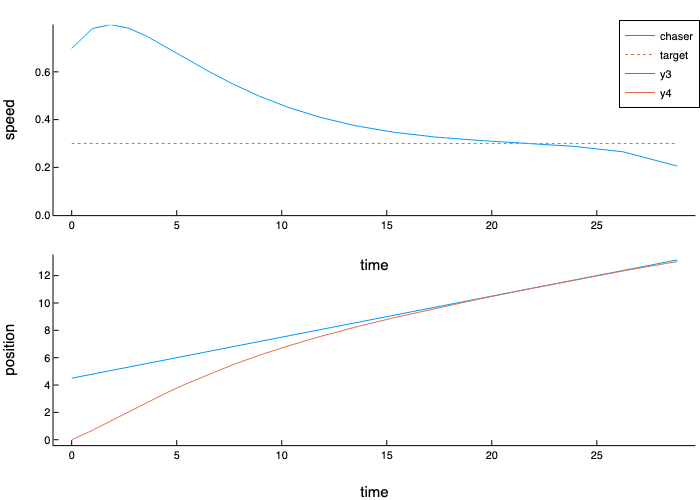

In [22]:
wstar4 = findgait(WalkRW2l(α=0.35,safety=true), target=:speed=>0.3, varying=:P)
ctime = 0. # cost of time, to encourage hurrying
cerror = 0.015
targetspeed = 0.3
targetdist = 4.5
result = optwalktag(wstar4, 20, ctime=ctime, cerror=cerror,targetspeed=targetspeed, targetdist=targetdist)
p = plot(layout=(2,1))
targettime = range(0, result.totaltime, length=50)
targetpos(t) = targetdist .+ targetspeed.*t
chasertime = cumsum([0;result.steps.tf])
chaserposn = cumsum([0; result.steps.steplength])
catcher = length(chaserposn)-1 #findfirst(chaserposn .>= targetpos.(chasertime))
plot!(p[1], chasertime[1:catcher], result.steps.speed[1:catcher],ylims=(0,Inf),xlabel="time",ylabel="speed",
    label="chaser")
plot!(p[1], chasertime[[1,catcher]],[targetspeed,targetspeed],linestyle=:dot,label="target")
plot!(p[2], chasertime[1:catcher], targetpos(chasertime[1:catcher]))
plot!(p[2], chasertime[1:catcher], chaserposn[1:catcher],xlabel="time",ylabel="position")